In [1]:
import matplotlib.pyplot as plt
import numpy as np
import serial

In [ ]:
#---------------------------------------------------------------
# Questions
#---------------------------------------------------------------
# 1. What is the structure of the vector R? Should it be seperate from the inductance? 
# 2. What does the paper mean by diagonal vector R?
# 3. Why does the paper say R is a square matrix?
# 4. Should we ignore imaginary part of complex matrices? Or should we use abs and ignore phase instead?
# 5. Double check if discarding right half of FFT result is doing the correct thing.
# 6. Double check if dot product is doing the right thing, because not working unless if arrays flattened.


In [10]:
#---------------------------------------------------------------
# Closing relays inorder to use SRC Voltage
#---------------------------------------------------------------
with serial.Serial("/dev/serial0", 115200, timeout=1) as ser:
    ser.reset_input_buffer() # clear input serial buffer
    ser.reset_output_buffer() # clear ouput serial buffer

    ser.write(b"-p p 5555\r") # get access to testing mode
    ser.write(b"-p a 3\r") # get access to factory testing mode
    ser.write(b"-m1\r") # reset faults
    ser.write(b"-sd8\r") # check mode. Must be in standby mode.
    
    # ser.write(b"-f f ?\r") # help on factory mode
    ser.write(b"-f f test_io\r") # put device in IO test mode
    # ser.write(b"-f i ?\r") # help on IO factory mode
    ser.write(b"-f i src_1=1\r") # close src_1 relay
    ser.write(b"-f i src_2=1\r") # close src_2 relay

    ser.close()

In [17]:
#---------------------------------------------------------------
# Reading data from Powerstar 10 card
#---------------------------------------------------------------

# Setup primary UART (miniUART) and read from Powerstar card
with serial.Serial("/dev/serial0", 115200, timeout=1) as ser:
    ser.reset_input_buffer() # clear input serial buffer
    ser.reset_output_buffer() # clear output serial buffer

    ser.write(b"-twh\r") # request headings for signals from Powerstar 10 card
    headings = [((x.strip()).strip(',')).split(',') for x in (((ser.read(1024)).strip()).strip('\r')).split('\r')] # read serial data in response to headings request. strip() necessary for any leading and trailing spaces in data
    print(headings)

    ser.write(b"-twrh\r"); ser.read(1024); # set to high resolution logging fadc = 10kHz
    # ser.write(b"-twrl\r"); ser.read(1024); # set to low resolution logging fadc = 1kHz

    ser.write(b"-tw\r") # request signals from Powerstar 10 card
    data = [((x.strip()).strip(',')).split(',') for x in (((ser.read(10000)).strip()).strip('\r')).split('\r')] # read serial data
    data = np.array(data[:-1]) # discard last list in data. Usually no complete.
    data = data.astype(np.float) # convert data array of strings to array of floats 
    data = np.transpose(data) # transpose data so that a list at each row is a buffer for a partricular measured quantity
    # print(data)

    src_v1 = data[0]/12 # source voltage
    src_i1 = data[2]/12 # source current

    ser.close()

[['Src Volts SIG', 'Inv Volts SIG', 'Src Amps SIG', 'Inv Amps SIG', 'Src V d', 'Src V q'], [''], ['Cmd Ok']]


<Container object of 3 artists>

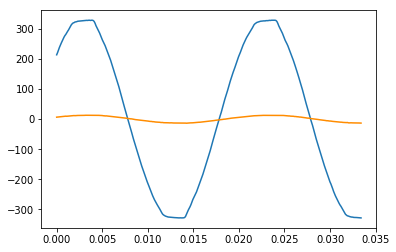

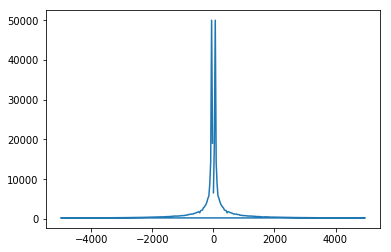

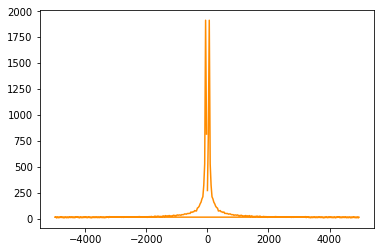

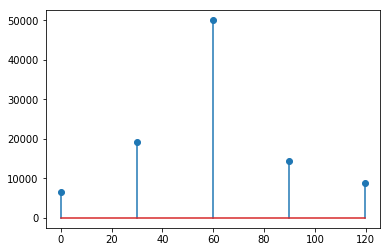

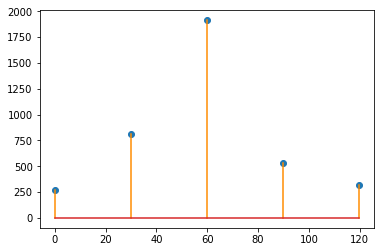

In [18]:
#---------------------------------------------------------------
# Performing FFT
#---------------------------------------------------------------

fadc = float(10000)                                 # sampling frequency of ADC. 1kHz for low resolution; 10kHz for high resolution.
nsamples = len(src_v1)                               # number of samples
tlen = nsamples/fadc
trunc = 5

t = np.linspace(0,tlen,nsamples) # generate time axis for signal

plt.plot(t, src_v1)
plt.plot(t, src_i1, color='darkorange')

SRC_V1 = np.fft.fft(src_v1) # perform FFT on source voltage
SRC_I1 = np.fft.fft(src_i1) # perform FFT on source voltage

freq = np.fft.fftfreq(len(t), 1/fadc) # obtain frequency axis

plt.figure(); plt.plot(freq, abs(SRC_V1))
plt.figure(); plt.plot(freq, abs(SRC_I1), color='darkorange')

plt.figure(); plt.stem(freq[:trunc], abs(SRC_V1)[:trunc]) # zoom in
plt.figure(); plt.stem(freq[:trunc], abs(SRC_I1)[:trunc], 'darkorange') # zoom in


In [49]:
#---------------------------------------------------------------
# Setting up input matrices
#---------------------------------------------------------------

NFFT = len(SRC_V1) # length of FFT. Used to discard right half of FFT result
nlines = 4 # number of lines

U1 = SRC_V1[:NFFT/2] # discard right half of FFT result
Is1 = SRC_I1[:NFFT/2] # discard right half of FFT result
R1 = np.ones(NFFT/2)*1000 # simulation
L1 = np.ones(NFFT/2)*0.05 # simulation

U2 = SRC_V1[:NFFT/2] # simulation
Is2 = SRC_I1[:NFFT/2] # simulation
R2 = np.ones(NFFT/2)*1000 # simulation
L2 = np.ones(NFFT/2)*0.05 # simulation

U3 = SRC_V1[:NFFT/2] # simulation
Is3 = SRC_I1[:NFFT/2] # simulation
R3 = np.ones(NFFT/2)*1000 # simulation
L3 = np.ones(NFFT/2)*0.05 # simulation

U4 = SRC_V1[:NFFT/2] # simulation
Is4 = SRC_I1[:NFFT/2] # simulation
R4 = np.ones(NFFT/2)*1000 # simulation
L4 = np.ones(NFFT/2)*0.05 # simulation

# Combine rows of measurements into matrices
U = (np.concatenate((U1, U2, U3, U4))).reshape(nlines, NFFT/2)
Is = (np.concatenate((Is1, Is2, Is3, Is4))).reshape(nlines, NFFT/2)
R = (np.concatenate((R1, R2, R3, R4))).reshape(nlines, NFFT/2)
L = (np.concatenate((L1, L2, L3, L4))).reshape(nlines, NFFT/2)

# Compute weighted matrices
Rsqrt = np.sqrt(R)

Rinv = np.ones((nlines, NFFT/2))
Rinv = np.divide(Rinv, R) # obtain matrix containing 1/R values

Isw = np.multiply(Is, Rsqrt) # compute Is' 

In [51]:
#---------------------------------------------------------------
# Perform GPT algorithm
#---------------------------------------------------------------

# Compute PPCC
Is_conj = np.conjugate(Is) # obtain Is*
PPCC = np.dot(U.flatten(), Is_conj.flatten())
print(PPCC)



(514272997.333+79356386.6487j)
